# Bad Beer or a Bad Pipette?  
**Fixed Measurement Error and Prior Specification in PyMC3**


This notebook reworks the pymc implementation of the cell counting model from Chapter 20 of Think Bayes 2 by Allen Downey.  The example originally comes from [this blog post](https://dataorigami.net/blogs/napkin-folding/bayesian-cell-counting), by Cameron Davidson-Pilon.

The basic model is: 
1. a yeast cell concentration to be inferred, 
2. a measurement error due to a number of laboratory dilution steps, and 
3. a yeast cell count observation.  

I have been struggling with this example for a while, due my conceptual model of measurement error (component #2).  To my thinking, measurement error is a quantity observed outside the model and should not be inferred by the observation.  Yet the measurement error (component #2) and the cell concentration (component #1) are treated the same way in the pymc3 model and are therefore both subject to inference.  If both the cell concentration and the measurement error are updated by the model, then the model can't tell the difference between bad beer (an out of range cell concentration), and a bad pipette (out of range measurement error)! 

To my thinking, if the measurement error is a known distribution, it should not be updated in the posterior, and the prior should match the posterior.  In updating the measurement error in the posterior, we are potentially biasing the the cell count inference (i.e., mistaking bad beer for a bad pipette)

The notebook runs through four versions of the model: 
1. A simplified version of the original model as a starting point.  
2. A rerun of the simplified model with a different observation to highlight my concerns.    
3. A rerun of the simplified model with a different observation and different priors to show the model working again.  
4. A rerun of the simplified model using the `RandomStream` functionality in pymc3 that allows for a use of a distribution that is not updated in the posterior.  

The punch line is that pymc does have the ability to use a "frozen" distribution that is not updated - this is shown in model #4.  However, with carefull specification of priors, a random variable may perform adequately - as shown in model #3.

## Imports

In [87]:
# If we're running on Colab, install libraries
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

# Get utils.py
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [88]:
from utils import set_pyplot_params
set_pyplot_params()
import numpy as np
from empiricaldist import Cdf
from utils import decorate
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import pandas as pd

## 1. Simplified Yeast Counting Model 
The original model includes a number of dilution steps on the yeast slurry.  In a separate notebook, I sampled the prior to estimate the combined effect so that I could simplify the model for the purpose of this exercise.  The measurement error is combined in a single term called `effective sample volume`, which converts between `yeast concentration (cells/mL)` to `yeast visible (cells)`.  It is a very small number:   

In [89]:
# effective sample volume mean and std were determined in a separate notebook
# these values are mL
effective_sample_volume_mean = 1.e-7
effective_sample_volume_std = 5.3e-9

# Multiplying by million turns mL into nL
MILLION = 1e6
effective_sample_volume_mean * MILLION, effective_sample_volume_std * MILLION

(0.09999999999999999, 0.0053)

The pymc model then becomes the following:

In [90]:
BILLION = 1e9
TOTAL_SQUARES = 25

squares_counted = 5
yeast_counted = 49

with pm.Model() as model:
    yeast_conc = pm.Normal("yeast conc (cells/mL)", mu=2 * BILLION, sd=0.4 * BILLION)
    effective_sample_volume = pm.TruncatedNormal("effective sample volume (nL)", lower=0,
                                            mu = effective_sample_volume_mean * MILLION,
                                            sigma =  effective_sample_volume_std * MILLION)

    yeast_visible = pm.Poisson("cells in visible portion", mu=yeast_conc * effective_sample_volume / MILLION)
    number_of_counted_cells = pm.Binomial("number of counted cells", 
                                          yeast_visible, squares_counted/TOTAL_SQUARES, 
                                          observed=yeast_counted)


Check that the model is generally in the right range with the prior predictive.  

In [91]:
with model:
    prior_sample = pm.sample_prior_predictive(10000)

# check prior
pd.DataFrame(prior_sample['number of counted cells']).describe().T


,count,mean,std,min,25%,50%,75%,max
0,10000.0,39.9447,10.462361,5.0,33.0,40.0,47.0,86.0


Sample

In [92]:
with model:
    trace = pm.sample()
    post_pred = pm.sample_posterior_predictive(trace)

C:\Users\GBRUNK~1\AppData\Local\Temp/ipykernel_8964/2081021944.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [effective sample volume (nL), yeast conc (cells/mL)]
>Metropolis: [cells in visible portion]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.31441766615770955, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5074932374923263, but should be close to 0.8. Try to increase the number of tuning steps.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.38329627484918083, but should be close to 0.8. Try to increase the number of tuning steps.
There were 280 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.19491798647493958, but should be clos

Analyze posterior

In [93]:
var_names  =['effective sample volume (nL)', 'yeast conc (cells/mL)']
az.summary(trace, var_names  =var_names)


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
effective sample volume (nL),1.010000e-01,6.000000e-03,9.000000e-02,1.110000e-01,1.000000e-03,0.000000e+00,86.0,184.0,1.04
yeast conc (cells/mL),2.379064e+09,4.077240e+08,1.747427e+09,3.166643e+09,6.472692e+07,4.731871e+07,58.0,44.0,1.03


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


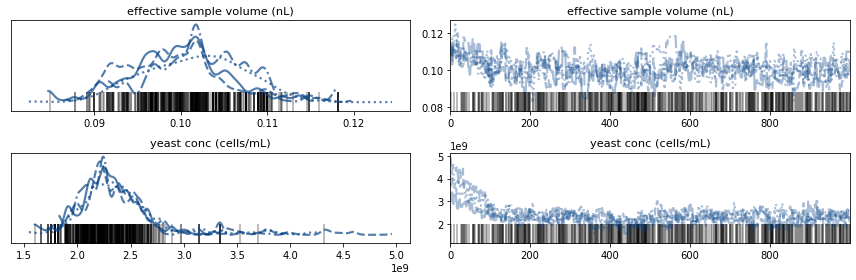

In [94]:
az.plot_trace(trace, var_names=var_names)
plt.tight_layout();

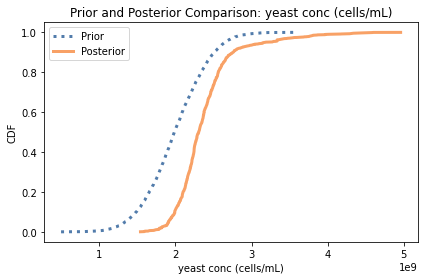

In [95]:
var = var_names[1]
cdf_prior = Cdf.from_seq(prior_sample[var])
cdf_post = Cdf.from_seq(trace[var])
cdf_prior.plot(label='Prior', style=':')
cdf_post.plot(label='Posterior')
decorate(xlabel=var,
         ylabel='CDF',
         title='Prior and Posterior Comparison: '+var)

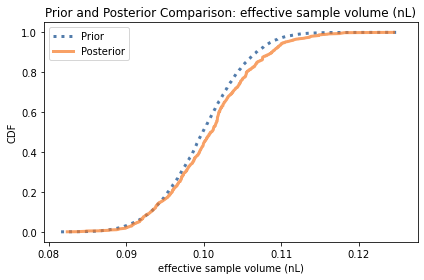

In [96]:
var = 'effective sample volume (nL)'
cdf_prior = Cdf.from_seq(prior_sample[var])
cdf_post = Cdf.from_seq(trace[var])
cdf_prior.plot(label='Prior', style=':')
cdf_post.plot(label='Posterior')
decorate(xlabel=var,
         ylabel='CDF',
         title='Prior and Posterior Comparison: '+var)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


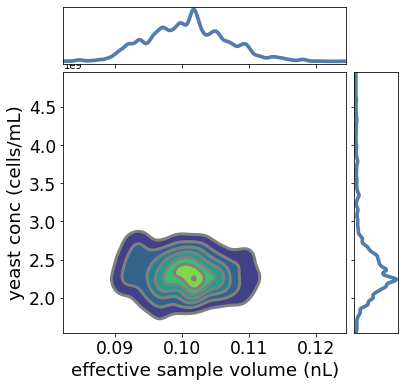

In [97]:
az.plot_pair(trace, var_names=var_names, marginals=True, kind='kde',figsize=(6,6));

Check posterior predictive

In [98]:
pd.DataFrame(post_pred).describe().T

,count,mean,std,min,25%,50%,75%,max
number of counted cells,4000.0,49.102,12.571898,20.0,41.0,47.0,53.0,133.0


**Notes**  
The traces could be better.  It is somewhat disconcerting that the effective sample volume does not match the prior.  In the next version, I'll throw "bad beer" data at the model to highlight this effect.  

## 2. Simplified Model with Bad Beer

Now let's assume that the yeast concentration is much larger than expected.

In [99]:
# revise yeast_counted from 49 in the example to make the value more extreme
yeast_counted = 150

with pm.Model() as model:
    yeast_conc = pm.Normal("yeast conc (cells/mL)", mu=2 * BILLION, sd=0.4 * BILLION)
    effective_sample_volume = pm.TruncatedNormal("effective sample volume (nL)", lower=0,
                                            mu = effective_sample_volume_mean * MILLION,
                                            sigma =  effective_sample_volume_std * MILLION)
    yeast_visible = pm.Poisson("cells in visible portion", mu=yeast_conc * effective_sample_volume / MILLION)
    number_of_counted_cells = pm.Binomial("number of counted cells", 
                                          yeast_visible, squares_counted/TOTAL_SQUARES, 
                                          observed=yeast_counted)


In [100]:
with model:
    prior_sample = pm.sample_prior_predictive(10000)

# check prior
pd.DataFrame(prior_sample['number of counted cells']).describe().T

,count,mean,std,min,25%,50%,75%,max
0,10000.0,40.1566,10.462534,8.0,33.0,40.0,47.0,85.0


Sample

In [101]:
with model:
    trace = pm.sample()
az.summary(trace, var_names  =var_names)

C:\Users\GBRUNK~1\AppData\Local\Temp/ipykernel_8964/1861265075.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [effective sample volume (nL), yeast conc (cells/mL)]
>Metropolis: [cells in visible portion]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
The acceptance probability does not match the target. It is 0.909549474160804, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9285661956045836, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8976717158821744, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9182926788073237, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the m

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
effective sample volume (nL),1.140000e-01,5.000000e-03,1.050000e-01,1.230000e-01,0.000000e+00,0.000,996.0,1281.0,1.00
yeast conc (cells/mL),4.162394e+09,2.636121e+08,3.676663e+09,4.672536e+09,1.306704e+07,9246422.005,408.0,850.0,1.01


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


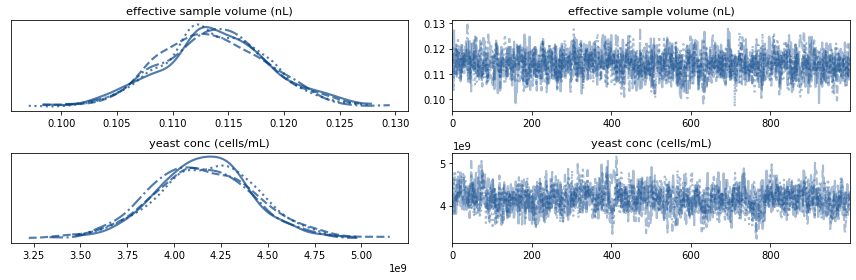

In [102]:
az.plot_trace(trace, var_names=var_names)
plt.tight_layout();

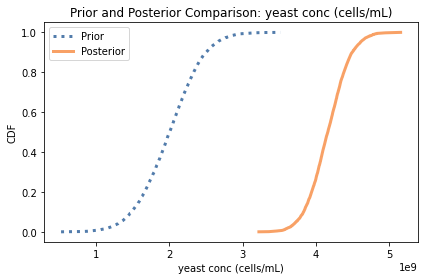

In [103]:
var = "yeast conc (cells/mL)"
cdf_prior = Cdf.from_seq(prior_sample[var])
cdf_post = Cdf.from_seq(trace[var])
cdf_prior.plot(label='Prior', style=':')
cdf_post.plot(label='Posterior')
decorate(xlabel=var,
         ylabel='CDF',
         title='Prior and Posterior Comparison: '+var)

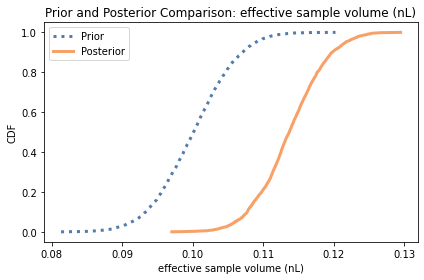

In [104]:
var = 'effective sample volume (nL)'
cdf_prior = Cdf.from_seq(prior_sample[var])
cdf_post = Cdf.from_seq(trace[var])
cdf_prior.plot(label='Prior', style=':')
cdf_post.plot(label='Posterior')
decorate(xlabel=var,
         ylabel='CDF',
         title='Prior and Posterior Comparison: '+var)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


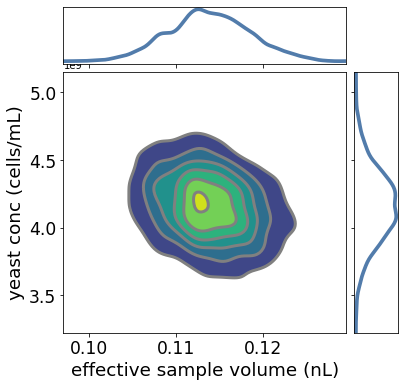

In [105]:
az.plot_pair(trace, var_names=var_names, marginals=True, kind='kde',figsize=(6,6));

**Notes**  
We can see from the summary table and graphs that the model is predicting both bad beer and a bad pipette.  The cell count was much larger than expected, resulting in both the concentration and the effective sample volume to be updated.    

## 3. Revised Model with Bad Beer and Revised Priors  

In this example, I will fix the observation error (for practical purposes) making sure that priors on the yeast concentration are only weakly informative.  

In [106]:

with pm.Model() as model:
    # revised yeast_conc priors
    yeast_conc = pm.TruncatedNormal("yeast conc (cells/mL)", mu=6* BILLION, sd=3 * BILLION, 
                                lower = 0.5*BILLION)
                                
    effective_sample_volume = pm.TruncatedNormal("effective sample volume (nL)", lower=0,
                                            mu = effective_sample_volume_mean * MILLION,
                                            sigma =  effective_sample_volume_std * MILLION)

    yeast_visible = pm.Poisson("cells in visible portion", 
                                mu=yeast_conc * effective_sample_volume / MILLION)

    number_of_counted_cells = pm.Binomial("number of counted cells", 
                                          yeast_visible, squares_counted/TOTAL_SQUARES, 
                                          observed=yeast_counted)


In [107]:
with model:
    prior_sample = pm.sample_prior_predictive(10000)

# check prior
pd.DataFrame(prior_sample['number of counted cells']).describe().T


,count,mean,std,min,25%,50%,75%,max
0,10000.0,123.8539,56.80037,6.0,82.0,121.0,161.0,362.0


The prior is within the right range.  

In [108]:
with model:   
    trace = pm.sample()
    post_pred = pm.sample_posterior_predictive(trace)
    

az.summary(trace, var_names  =var_names)

C:\Users\GBRUNK~1\AppData\Local\Temp/ipykernel_8964/2565572135.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [effective sample volume (nL), yeast conc (cells/mL)]
>Metropolis: [cells in visible portion]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
The acceptance probability does not match the target. It is 0.8823911264851538, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
effective sample volume (nL),1.000000e-01,5.000000e-03,9.100000e-02,1.100000e-01,0.000000e+00,0.000000e+00,824.0,983.0,1.00
yeast conc (cells/mL),7.525188e+09,7.163584e+08,6.212103e+09,8.872602e+09,4.711967e+07,3.336078e+07,227.0,418.0,1.02


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


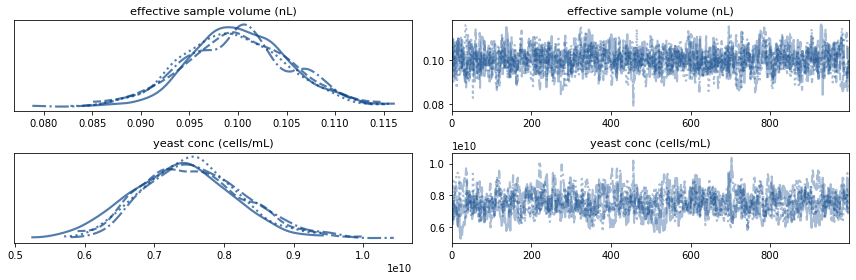

In [109]:
az.plot_trace(trace, var_names=var_names)
plt.tight_layout();

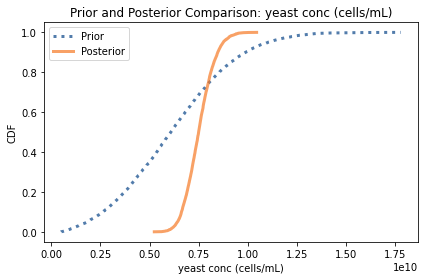

In [110]:
var = "yeast conc (cells/mL)"
cdf_prior = Cdf.from_seq(prior_sample[var])
cdf_post = Cdf.from_seq(trace[var])
cdf_prior.plot(label='Prior', style=':')
cdf_post.plot(label='Posterior')
decorate(xlabel=var,
         ylabel='CDF',
         title='Prior and Posterior Comparison: '+var)

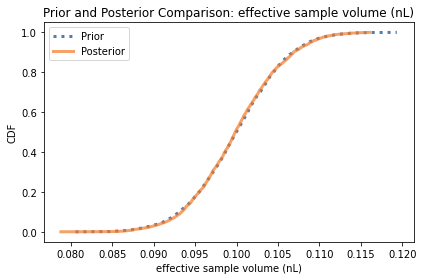

In [111]:
var = 'effective sample volume (nL)'
cdf_prior = Cdf.from_seq(prior_sample[var])
cdf_post = Cdf.from_seq(trace[var])
cdf_prior.plot(label='Prior', style=':')
cdf_post.plot(label='Posterior')
decorate(xlabel=var,
         ylabel='CDF',
         title='Prior and Posterior Comparison: '+var)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


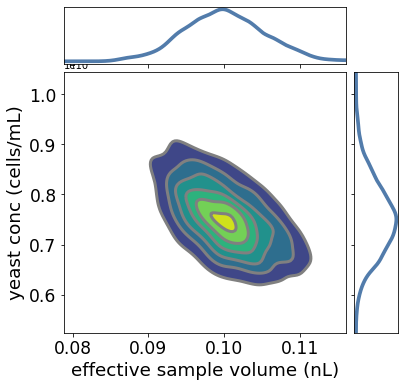

In [112]:
az.plot_pair(trace, var_names=var_names, marginals=True, kind='kde',figsize=(6,6));

**Notes**  
In the last example, widening the prior for the yeast concentration parameter resulted in the measurement error term being constant, and the yeast concentration parameter being much higher and closer to the expected value.  

# 4. Revised Model with a Fixed Distribution using `RandomStream`

In this example, I will fix the observation error using the `RandomStream` utility in pymc3.  The observed data will be the same as Model #1 to see if this changes the inference.   

In [113]:
import theano.tensor as tt
rand_stream = tt.random.utils.RandomStream()

In [114]:
yeast_counted = 49
with pm.Model() as model:
    yeast_conc = pm.Normal("yeast conc (cells/mL)", mu=2 * BILLION, sd=0.4 * BILLION)
    # effective sample volume is a deterministic stochastic variable
    # no contradiction there!
    effective_sample_volume = pm.Deterministic("effective sample volume (nL)",
                                            rand_stream.normal(
                                                effective_sample_volume_mean * MILLION,
                                                effective_sample_volume_std * MILLION))

    yeast_visible = pm.Poisson("cells in visible portion", mu=yeast_conc * effective_sample_volume / MILLION)
    number_of_counted_cells = pm.Binomial("number of counted cells", 
                                          yeast_visible, squares_counted/TOTAL_SQUARES, 
                                          observed=yeast_counted)

In [115]:
with model:
    prior_sample = pm.sample_prior_predictive(10000)

# check prior
pd.DataFrame(prior_sample['number of counted cells']).describe().T


,count,mean,std,min,25%,50%,75%,max
0,10000.0,38.3542,9.837714,1.0,31.0,38.0,45.0,81.0


Sample

In [116]:
with model:
    trace = pm.sample()
    post_pred = pm.sample_posterior_predictive(trace)

C:\Users\GBRUNK~1\AppData\Local\Temp/ipykernel_8964/2081021944.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [yeast conc (cells/mL)]
>Metropolis: [cells in visible portion]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 102 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Analyze posterior

In [117]:
var_names  =['effective sample volume (nL)', 'yeast conc (cells/mL)']
az.summary(trace, var_names  =var_names)


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
effective sample volume (nL),1.000000e-01,5.000000e-03,9.000000e-02,1.100000e-01,0.000000e+00,0.000000e+00,3914.0,3918.0,1.00
yeast conc (cells/mL),2.267487e+09,2.871564e+08,1.724496e+09,2.795408e+09,2.160024e+07,1.534695e+07,180.0,324.0,1.02


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


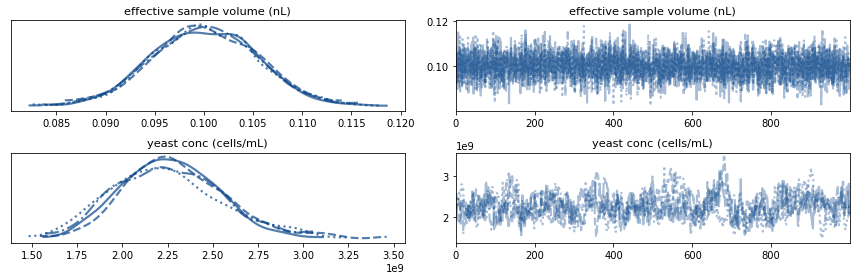

In [118]:
az.plot_trace(trace, var_names=var_names)
plt.tight_layout();

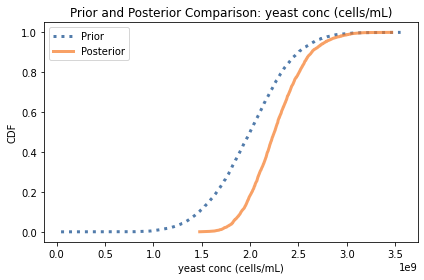

In [119]:
var = var_names[1]
cdf_prior = Cdf.from_seq(prior_sample[var])
cdf_post = Cdf.from_seq(trace[var])
cdf_prior.plot(label='Prior', style=':')
cdf_post.plot(label='Posterior')
decorate(xlabel=var,
         ylabel='CDF',
         title='Prior and Posterior Comparison: '+var)

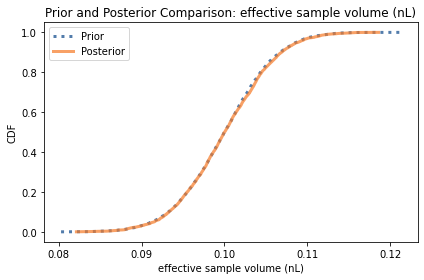

In [120]:
var = 'effective sample volume (nL)'
# note that the prior predictive doesn't seem to work
# with the rand stream - resample using numpy for plotting purposes
cdf_prior = Cdf.from_seq(np.random.normal(effective_sample_volume_mean * MILLION,
                    effective_sample_volume_std * MILLION, size = 10000))
cdf_post = Cdf.from_seq(trace[var])
cdf_prior.plot(label='Prior', style=':')
cdf_post.plot(label='Posterior')
decorate(xlabel=var,
         ylabel='CDF',
         title='Prior and Posterior Comparison: '+var)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


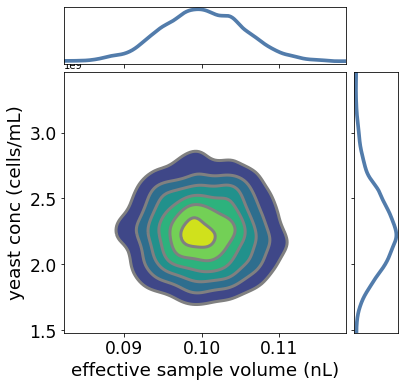

In [121]:
az.plot_pair(trace, var_names=var_names, marginals=True, kind='kde',figsize=(6,6));

Check posterior predictive

In [122]:
pd.DataFrame(post_pred).describe().T

,count,mean,std,min,25%,50%,75%,max
number of counted cells,4000.0,45.90275,8.197109,22.0,40.0,45.0,51.0,84.0


**Notes**  
The traces are better behaved with the fixed distribution being used, and there is no correlation between the sample volume and the inferred yeast concentration, consistent with my interpretation of the problem.    
 

# Summary
* `RandomStream` allows the use of a fixed distribution under the hood in a pymc3 model.
* With careful prior specification, the measurement error can be added to the model with the expected outcome that it will remain similar to the prior.  

